# Cellpose Segmentation

In [1]:
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scportrait.pipeline.featurization import CellFeaturizer, ConvNeXtFeaturizer
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import CytosolSegmentationCellpose
from scportrait.pipeline.selection import LMDSelection

/Users/sophia/mambaforge/envs/scPortrait_dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_location = "project"

project = Project(
    os.path.abspath(project_location),
    config_path="config_example1.yml",
    overwrite=True,
    debug=True,
    segmentation_f=CytosolSegmentationCellpose,
    extraction_f=HDF5CellExtraction,
    featurization_f=ConvNeXtFeaturizer,
)

Updating project config file.
[04/03/2025 12:33:11] Loading config from /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/project/config.yml
[04/03/2025 12:33:12] Compression algorithm for extracted single-cell images: lzf
[04/03/2025 12:33:12] No cache directory specified in config using current working directory /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development.


In [3]:
from scportrait.data._datasets import dataset_1

dataset_1_path = dataset_1()

# these example images are downloaded from the human protein atlas (www.proteinatlas.org)
images = [f"{dataset_1_path}/Ch1.tif", f"{dataset_1_path}/Ch2.tif", f"{dataset_1_path }/Ch3.tif"]

project.load_input_from_tif_files(images)

[03/03/2025 23:04:50] Output location /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/project/scportrait.sdata already exists. Overwriting.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/project/scportrait.sdata         
[03/03/2025 23:04:50] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/Project_lpkdreg5 for Project
[03/03/2025 23:04:50] Image input_image written to sdata object.
[03/03/2025 23:04:51] Cleaned up temporary directory at <TemporaryDirectory '/Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/Project_lpkdreg5'>


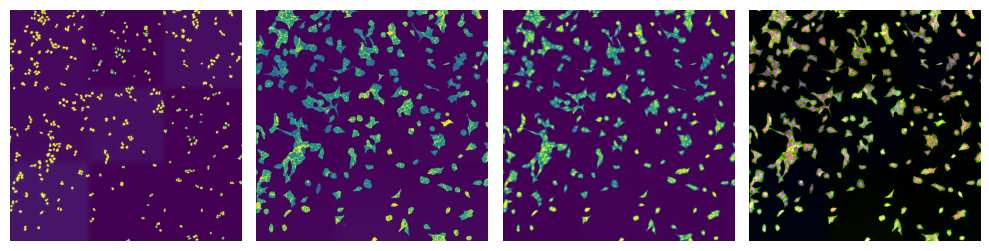

In [4]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time

def colorize(im, color, clip_percentile=0.0):
    """
    Helper function to create an RGB image from a single-channel image using a
    specific color.
    """
    # Check that we do just have a 2D image
    if im.ndim > 2 and im.shape[2] != 1:
        raise ValueError("This function expects a single-channel image!")

    # Rescale the image according to how we want to display it
    im_scaled = im.astype(np.float32) - np.percentile(im, clip_percentile)
    im_scaled = im_scaled / np.percentile(im_scaled, 100 - clip_percentile)
    im_scaled = np.clip(im_scaled, 0, 1)

    # Need to make sure we have a channels dimension for the multiplication to work
    im_scaled = np.atleast_3d(im_scaled)

    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return im_scaled * color


def generate_composite(images, colors=None, plot=False):
    if colors is None:
        colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0), (1, 0, 1)]
    colorized = []
    for image, color in zip(images, colors, strict=False):
        image = colorize(image, color, 0.0)
        colorized.append(image)

    if plot:
        for i in colorized:
            plt.figure()
            plt.imshow(i)

    image = colorized[0]
    for i in range(len(colorized) - 1):
        image += colorized[i + 1]

    return np.clip(image, 0, 1)


fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].imshow(project.input_image[0])
axs[0].axis("off")

axs[1].imshow(project.input_image[1])
axs[1].axis("off")

axs[2].imshow(project.input_image[2])
axs[2].axis("off")

img = generate_composite(project.input_image)

axs[3].imshow(img)
axs[3].axis("off")

fig.tight_layout()

[03/03/2025 23:04:54] For cytosol segmentation using the maximum intensity projection of channels [1, 2].
[03/03/2025 23:04:54] GPU Status for segmentation is True and will segment using the following device mps.
[03/03/2025 23:04:54] Segmenting nucleus using the following model: nuclei
[03/03/2025 23:05:03] Segmenting cytosol using the following model: cyto2


/Users/sophia/mambaforge/envs/scPortrait_dev/lib/python3.11/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)


[03/03/2025 23:05:14] Performing filtering to match Cytosol and Nucleus IDs.
[03/03/2025 23:05:25] Removed 148 nuclei and 61 cytosols due to filtering.
[03/03/2025 23:05:25] After filtering, 378 matching nuclei and cytosol masks remain.
[03/03/2025 23:05:29] Total time to perform nucleus and cytosol mask matching filtering: 15.24 seconds
[03/03/2025 23:05:29] Segmentation seg_all_nucleus written to sdata object.
[03/03/2025 23:05:30] Points centers_seg_all_nucleus written to sdata object.
[03/03/2025 23:05:31] Segmentation seg_all_cytosol written to sdata object.
[03/03/2025 23:05:31] Points centers_seg_all_cytosol written to sdata object.


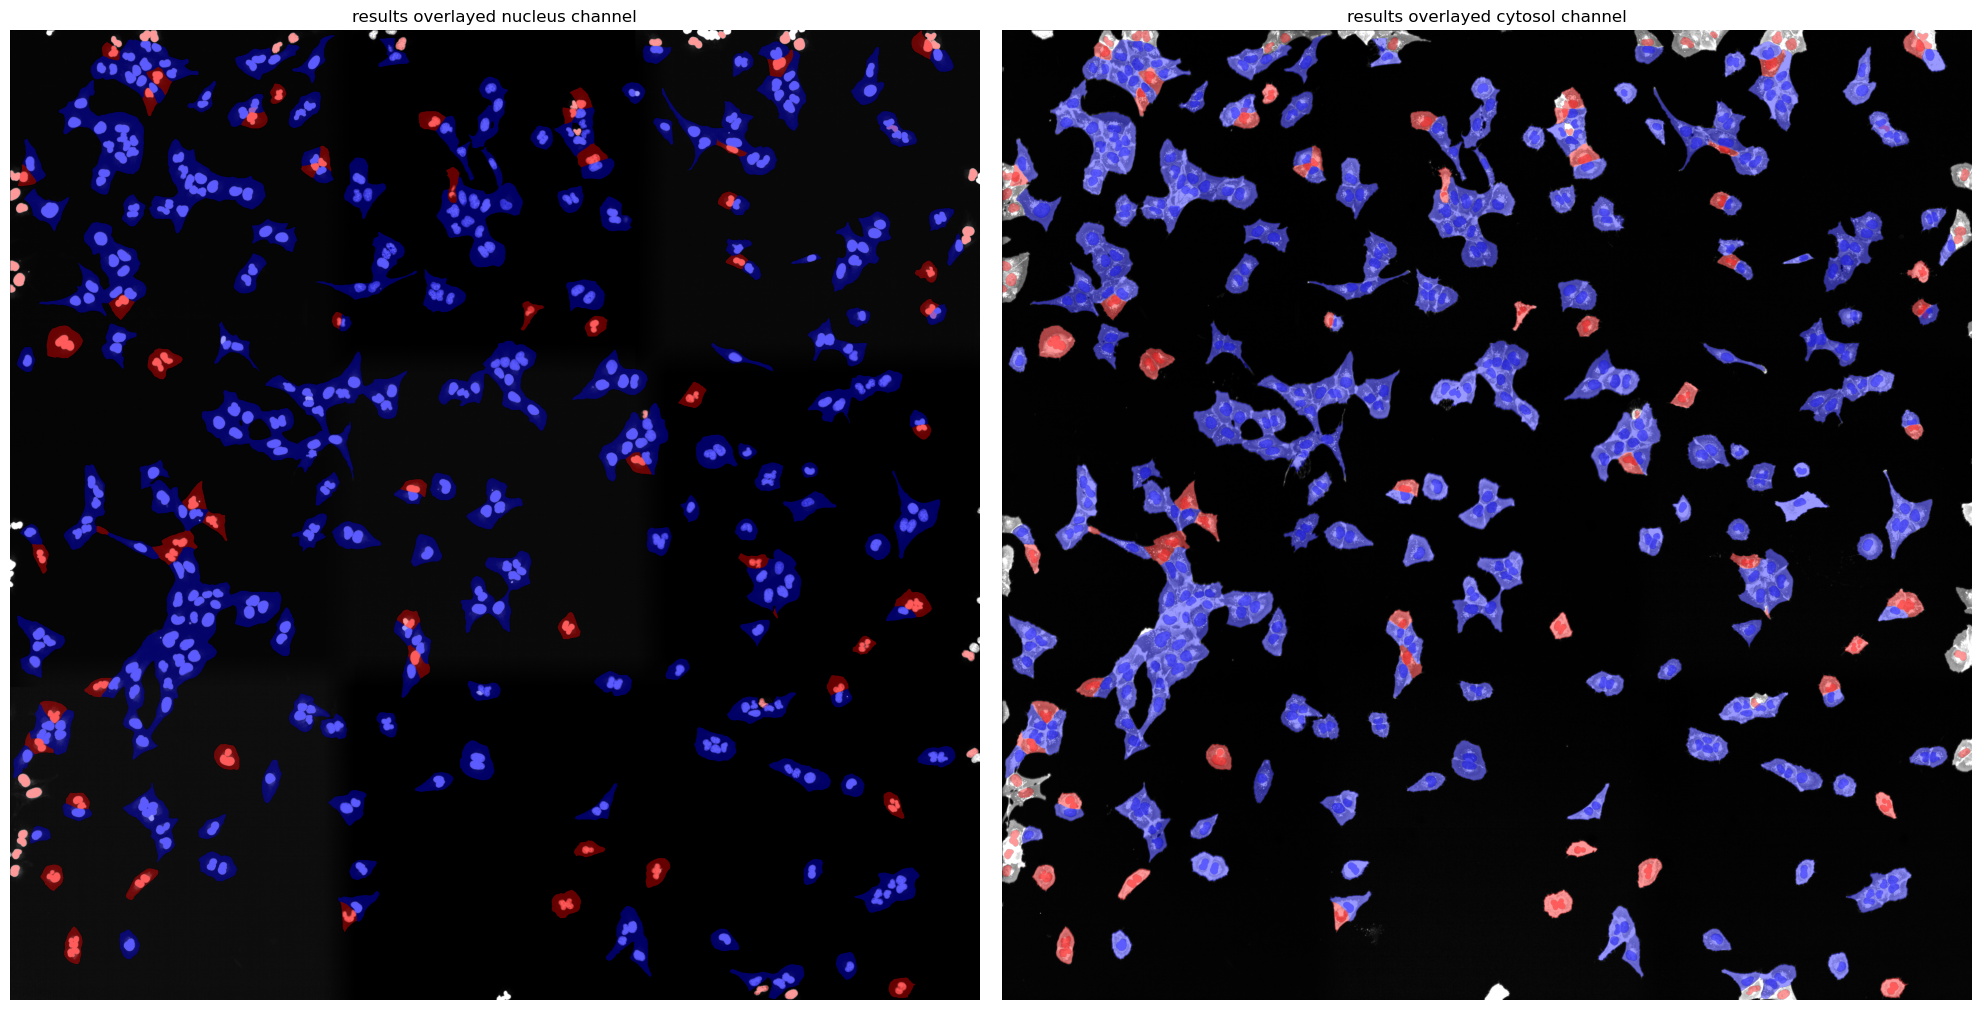

In [5]:
project.segment()

(-0.5, 3036.5, 3038.5, -0.5)

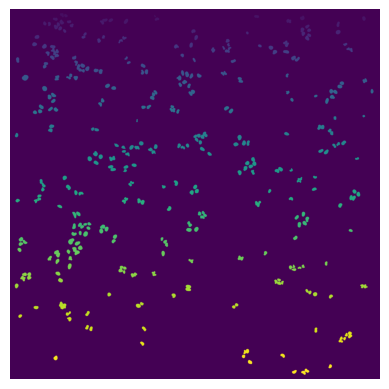

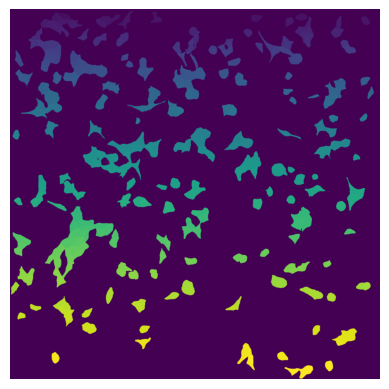

In [6]:
plt.figure()
plt.imshow(project.sdata["seg_all_nucleus"])
plt.axis("off")

plt.figure()
plt.imshow(project.sdata["seg_all_cytosol"])
plt.axis("off")

In [7]:
project.extract()

[03/03/2025 23:05:38] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_g285hxvw for HDF5CellExtraction
[03/03/2025 23:05:38] Created new directory for extraction results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/project/extraction/data
[03/03/2025 23:05:38] Setup output folder at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/project/extraction/data
[03/03/2025 23:05:38] Found 2 segmentation masks for the given key in the sdata object. Will be extracting single-cell images based on these masks: ['seg_all_nucleus', 'seg_all_cytosol']
[03/03/2025 23:05:38] Using seg_all_nucleus as the main segmentation mask to determine cell centers.
[03/03/2025 23:05:38] A total of 10 cells were too close to the image border to be extracted. Their cell_ids were saved to file /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/project/extraction/removed_classes.csv.
[03/0

Extracting cell batches: 100%|██████████| 4/4 [00:00<00:00, 16.54it/s]


[03/03/2025 23:05:39] Finished extraction in 0.51 seconds (715.67 cells / second)
[03/03/2025 23:05:39] Benchmarking times saved to file.
[03/03/2025 23:05:39] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_g285hxvw'>


(368, 5, 128, 128)


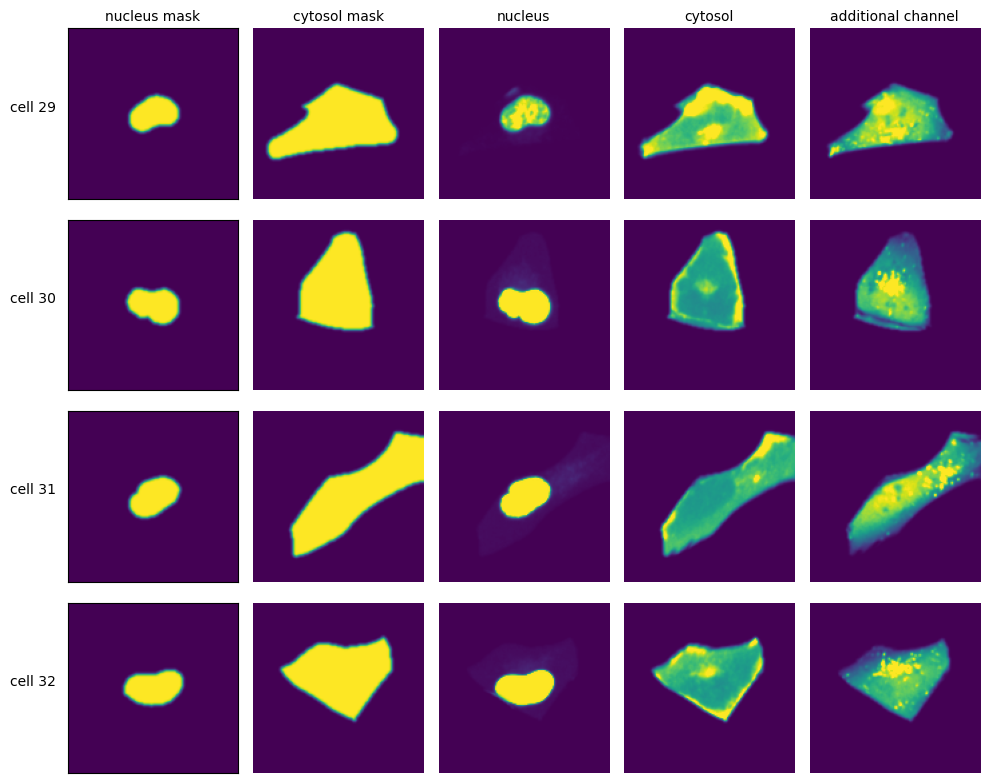

In [8]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    print(images.shape)

    n_cells = [2, 3, 4, 5]
    fig, axs = plt.subplots(len(n_cells), 5, figsize=(5 * 2, len(n_cells) * 2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]

    for i, id in enumerate(n_cells):
        cell_id = index[id][1]
        image = images[id]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)
    fig.tight_layout()

In [3]:
project.featurize()

Using extraction directory: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/project/extraction/data/single_cells.h5
[04/03/2025 12:33:20] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/ConvNeXtFeaturizer_3e_zhya8 for ConvNeXtFeaturizer
[04/03/2025 12:33:20] Overwrite flag is set, deleting existing directory for featurization results.
[04/03/2025 12:33:20] Created new directory for featurization results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/project/featurization/complete_ConvNeXtFeaturizer
[04/03/2025 12:33:20] Automatically configured inference device to mps


/Users/sophia/mambaforge/envs/scPortrait_dev/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[04/03/2025 12:33:23] Reading data from path: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/project/extraction/data/single_cells.h5
[04/03/2025 12:33:23] Processing dataset with 368 cells
[04/03/2025 12:33:23] Dataloader generated with a batchsize of 900 and 10 workers. Dataloader contains 1 entries.
[04/03/2025 12:33:23] Started processing of 1 batches.
[04/03/2025 12:33:33] finished processing.
[04/03/2025 12:33:34] Results saved to file: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/project/featurization/complete_ConvNeXtFeaturizer/calculated_image_features.csv
[04/03/2025 12:33:34] Table ConvNeXtFeaturizer_ConvNeXt_nucleus written to sdata object.
[04/03/2025 12:33:34] Table ConvNeXtFeaturizer_ConvNeXt_cytosol written to sdata object.
[04/03/2025 12:33:34] GPU memory before performing cleanup: {'MPS': '133682.09375 MiB'}
[04/03/2025 12:33:35] GPU memory after performing cleanup: {'MPS': '94634.09375 MiB'}
[04/03/2025 12:33:35] C

In [4]:
from scportrait.pipeline.featurization import CellFeaturizer

project.update_featurization_f(CellFeaturizer)
project.featurize()

[04/03/2025 12:33:35] Replacing current featurization method <class 'scportrait.pipeline.featurization.ConvNeXtFeaturizer'> with <class 'scportrait.pipeline.featurization.CellFeaturizer'>
[04/03/2025 12:33:35] No cache directory specified in config using current working directory /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development.
Using extraction directory: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/project/extraction/data/single_cells.h5
[04/03/2025 12:33:35] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/CellFeaturizer_qfgochri for CellFeaturizer
[04/03/2025 12:33:35] Started CellFeaturization of all available channels.
[04/03/2025 12:33:35] Created new directory for featurization results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/project/featurization/complete_CellFeaturizer
[04/03/2025 12:33:35] CPU specified in config file but MPS availab

In [5]:
from scportrait.pipeline.featurization import MLClusterClassifier

project.update_featurization_f(MLClusterClassifier)
project.featurize()

[04/03/2025 12:33:46] Replacing current featurization method <class 'scportrait.pipeline.featurization.CellFeaturizer'> with <class 'scportrait.pipeline.featurization.MLClusterClassifier'>
[04/03/2025 12:33:46] No cache directory specified in config using current working directory /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development.


Lightning automatically upgraded your loaded checkpoint from v1.5.5 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../src/scportrait/scportrait_data/vgg_autophagy_classifier/VGG2_autophagy_classifier2.1.cpkt`


Using extraction directory: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/project/extraction/data/single_cells.h5
[04/03/2025 12:33:46] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/MLClusterClassifier_x0p5ra8l for MLClusterClassifier
[04/03/2025 12:33:46] Started MLClusterClassifier classification.
[04/03/2025 12:33:46] Created new directory for featurization results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/project/featurization/complete_Autophagy_15h_classifier2_1
[04/03/2025 12:33:46] CPU specified in config file but MPS available on system. Consider changing the device for the next run.
[04/03/2025 12:33:46] Model class defined as <class 'scportrait.tools.ml.plmodels.MultilabelSupervisedModel'>
[04/03/2025 12:33:46] Reading data from path: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/project/extraction/data/single_cells.h5
[04/03/2025